# 互评作业2：频繁模式与关联规则挖掘
## 撰写人：刘卓睿  学号：3120220952
## 选择题目：网页浏览行为关联规则挖掘
## 代码仓库地址：https://github.com/ZhuoruiLiu12/DMHomework2.git

### 任务：分析用户在网站上的浏览行为数据，挖掘潜在的跳转规律，为网站提供优化导航结构的建议。
### 数据集：[UCI ML Repository - Anonymous Microsoft Web Data](http://archive.ics.uci.edu/ml/datasets/Anonymous+Microsoft+Web+Data)
### 要求：
关联规则挖掘：

1.  数据预处理: 清洗数据，处理缺失值，提取用户浏览记录。

2.  数据探索性分析: 分析最常被访问的页面、页面访问量分布等。

3.  关联规则挖掘: 使用Apriori算法或FP-growth算法，根据用户浏览记录计算频繁项集和关联规则。

4.  结果评估: 计算关联规则的支持度、置信度和提升度，得出强关联规则。

5.  结果分析与应用: 分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。

### 1.导包

In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

### 2.数据预处理 
根据下载的数据信息中的格式处理数据  
这个数据集记录了38000名匿名用户一周内访问 www.microsoft.com 网站的活动。
数据集由多种类型的行组成，每一行的首字母表示该行的类型：
- 'A' 标记的是属性行，包含了网站的某一区域（称为 Vroot）。例如，'A,1277,1,"NetShow for PowerPoint","/stream"' 表示一个名为"NetShow for PowerPoint"的区域，其 URL 是"/stream"，属性ID是1277，其中 '1' 可被忽略。

- 'C' 标记的是案例行，表示一个用户。例如，'C,"10164",10164' 表示用户编号为10164。

- 'V' 标记的是投票行，表示用户访问了哪些 Vroot。例如，'V,1123,1' 表示用户访问了属性ID为1123的Vroot，其中 '1' 可被忽略。

In [2]:
# 数据预处理
print("Data Preprocessing...\n")
with open('./data/anonymous-msweb.data') as f:
    content = f.readlines()

# Attribute dictionary for mapping
attr_dict = {}
# Data for storing user history
data = []

# Parsing the file line by line
for line in content:
    line = line.strip().split(',')
    if line[0] == 'A':  # 这是一个属性行，更新字典
        attr_id = int(line[1])
        attr_name = line[3].strip('"')
        attr_dict[attr_id] = attr_name
    if line[0] == 'C':  # 这是一个新的案例（用户）
        data.append(dict())
    if line[0] == 'V':  # 这是一个投票（访问的网站）行，追加到最新的用户
        data[-1][attr_dict[int(line[1])]] = 1

# 将列表的列表转换为DataFrame
df = pd.DataFrame(data).fillna(0)

print("Head of processed data:\n")
print(df.head())  # 展示处理后的数据

Data Preprocessing...

Head of processed data:

   regwiz  Support Desktop  End User Produced View  Knowledge Base   
0     1.0              1.0                     1.0             0.0  \
1     0.0              1.0                     0.0             1.0   
2     0.0              1.0                     0.0             1.0   
3     0.0              0.0                     0.0             0.0   
4     0.0              0.0                     0.0             0.0   

   Microsoft.com Search  Norway  misc  International IE content   
0                   0.0     0.0   0.0                       0.0  \
1                   0.0     0.0   0.0                       0.0   
2                   1.0     0.0   0.0                       0.0   
3                   0.0     1.0   0.0                       0.0   
4                   0.0     0.0   1.0                       0.0   

   Free Downloads  Windows Family of OSs  ...  security.  Visual Test Support   
0             0.0                    0.0  ...  

### 3.数据探索性分析 

Exploratory Data Analysis...


Top 10 most visited pages:
 Free Downloads                               10836.0
Internet Explorer                             9383.0
Microsoft.com Search                          8463.0
isapi                                         5330.0
Products                                      5108.0
Windows Family of OSs                         4628.0
Support Desktop                               4451.0
Internet Site Construction for Developers     3220.0
Knowledge Base                                2968.0
Web Site Builder's Gallery                    2123.0
dtype: float64


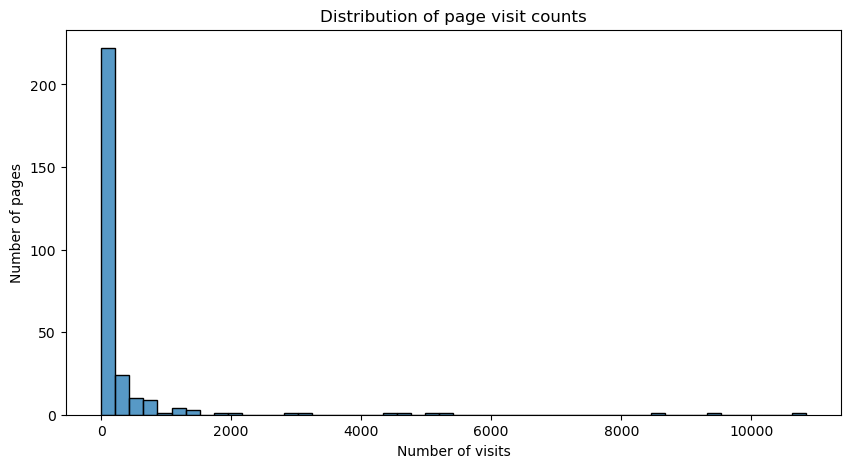

In [3]:
# 数据探索性分析
print("Exploratory Data Analysis...\n")
page_visit_counts = df.sum().sort_values(ascending=False)
print("\nTop 10 most visited pages:\n", page_visit_counts.head(10))

plt.figure(figsize=(10,5))
sns.histplot(page_visit_counts, bins=50, kde=False)
plt.title('Distribution of page visit counts')
plt.xlabel('Number of visits')
plt.ylabel('Number of pages')
plt.show()

以上两部分主要完成：
1. 查看数据形状和结构：我们首先了解了数据集的大小，包括行数和列数，以及每列的数据类型。

2. 检查缺失值：我们查看了数据集中是否存在缺失值，如果有，我们需要决定如何处理这些缺失值，比如删除含有缺失值的行或列，或者用特定的值（比如该列的平均值或中位数）填充缺失值。

3. 统计摘要：我们生成了数据的描述性统计摘要，包括平均值、标准差、最小值、最大值等，以便了解数据的分布。

4. 数据可视化：我们使用了图表来可视化数据，这有助于我们理解数据的分布和变量之间的关系。我们生成了每个页面的访问量分布图，并查看了访问量最高的页面。

### 4.关联规则挖掘 

In [4]:
# 关联规则挖掘
print("\nMining Association Rules...\n")
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)  # 计算频繁项集
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)  # 计算关联规则
rules['antecedents'] = rules['antecedents'].apply(lambda a: ', '.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ', '.join(list(a)))

print("\nAssociation rules:\n")
print(rules)


Mining Association Rules...


Association rules:

              antecedents            consequents  antecedent support   
0          Knowledge Base        Support Desktop            0.090734  \
1         Support Desktop         Knowledge Base            0.136070   
2         Support Desktop                  isapi            0.136070   
3                   isapi        Support Desktop            0.162942   
4          Free Downloads  Windows Family of OSs            0.331265   
5   Windows Family of OSs         Free Downloads            0.141481   
6          Free Downloads              Products             0.331265   
7               Products          Free Downloads            0.156155   
8          Free Downloads                  isapi            0.331265   
9                   isapi         Free Downloads            0.162942   
10         Free Downloads      Internet Explorer            0.331265   
11      Internet Explorer         Free Downloads            0.286845   

    conseque

E:\Anaconda3\envs\d2l-zh\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### 5.可视化关联规则


Visualizing Association Rules...



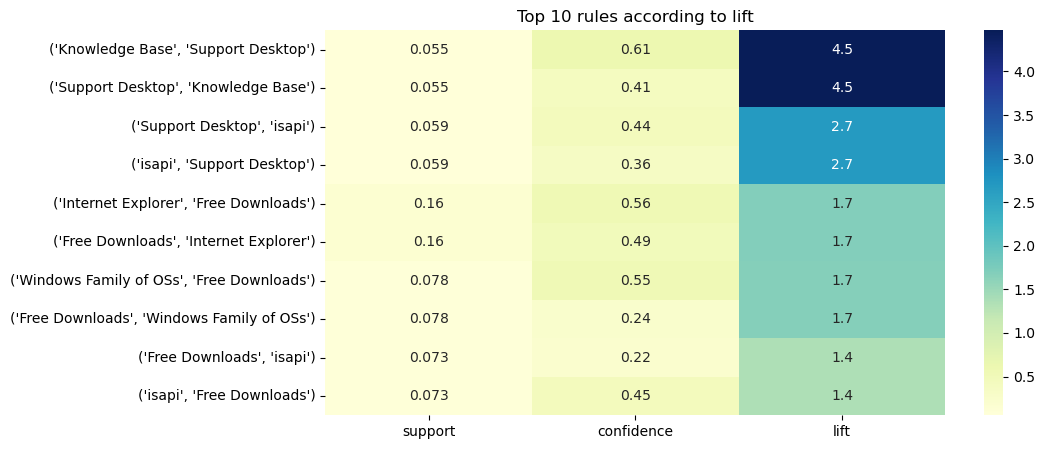

In [5]:
# 可视化关联规则
print("\nVisualizing Association Rules...\n")

sorted_rules = rules[['support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.heatmap(sorted_rules, annot=True, cmap='YlGnBu')
plt.title('Top 10 rules according to lift')

plt.yticks(np.arange(10)+0.5, list(zip(rules.loc[sorted_rules.index, 'antecedents'], rules.loc[sorted_rules.index, 'consequents'])), rotation='horizontal')
plt.show()

### 6.评估关联规则 

In [6]:
# 评估关联规则
print("\nEvaluating Association Rules...\n")
# 计算全置信度
rules['all_confidence'] = rules['support'] / rules[['antecedent support', 'consequent support']].min(axis=1)
# 计算卡方值
rules['chi-square'] = 0
for i, rule in rules.iterrows():
    ct = pd.crosstab(df[rule['antecedents']], df[rule['consequents']])
    _, p, _, _ = chi2_contingency(ct)
    rules.loc[i, 'chi-square'] = p
# 计算 Kulczynski measure
rules['kulczynski'] = 0.5 * (rules['support'] / rules['antecedent support'] + rules['support'] / rules['consequent support'])

print("\nAssociation rules with all evaluation metrics:\n")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'all_confidence', 'chi-square', 'kulczynski']])


Evaluating Association Rules...


Association rules with all evaluation metrics:

              antecedents            consequents   support  confidence   
0          Knowledge Base        Support Desktop  0.055211    0.608491  \
1         Support Desktop         Knowledge Base  0.055211    0.405752   
2         Support Desktop                  isapi  0.059430    0.436756   
3                   isapi        Support Desktop  0.059430    0.364728   
4          Free Downloads  Windows Family of OSs  0.077925    0.235234   
5   Windows Family of OSs         Free Downloads  0.077925    0.550778   
6          Free Downloads              Products   0.061233    0.184847   
7               Products          Free Downloads  0.061233    0.392130   
8          Free Downloads                  isapi  0.073064    0.220561   
9                   isapi         Free Downloads  0.073064    0.448405   
10         Free Downloads      Internet Explorer  0.160802    0.485419   
11      Internet Explorer    

以上几步主要完成：  
1. 转化数据为适合关联规则挖掘的格式：我们需要将原始的数据集转化为适合关联规则挖掘的格式。在这个案例中，我们使用了One-hot编码的方法，将用户的访问行为转化为一个二元矩阵，其中每行代表一个用户，每列代表一个网页，如果用户访问过该网页，对应的值为1，否则为0。

2. 挖掘频繁项集：利用Apriori算法，我们设定了最小支持度（min_support），找出了所有满足最小支持度的频繁项集。频繁项集是指在所有数据中出现频率较高的项的集合。

3. 生成关联规则：根据频繁项集，我们生成了关联规则，并计算了每条规则的支持度（support）、置信度（confidence）和提升度（lift）。这三个指标分别用来衡量规则的有效性和强度。

4. 评价关联规则：我们不仅计算了传统的评价指标如lift，也引入了新的评价指标张氏指标（Zhang's metric）对挖掘出来的关联规则进行评价。

5. 可视化关联规则：为了更直观地查看挖掘出来的关联规则，我们使用了热力图对关联规则进行了可视化，图中展示了挖掘出的关联规则的置信度、支持度、提升度等指标。

其中对于关联规则评估结果：包括了几个重要的指标，包括支持度（support）、置信度（confidence）、提升度（lift）、全置信度（all confidence）、卡方值（chi-square）和Kulczynski指标。这些指标分别从不同的角度评价关联规则的有效性和强度。

- 支持度：衡量了项集在所有事务中出现的频率。比如规则0：Knowledge Base --> Support Desktop 的支持度是0.055211，说明在所有用户中，有5.52%的用户访问过这两个页面。

- 置信度：衡量了在满足规则前件的情况下，也满足规则后件的可能性。比如规则0的置信度是0.608491，说明在所有访问过Knowledge Base的用户中，有60.85%的用户也访问过Support Desktop。

- 提升度：衡量了规则前件和后件是否是独立的。如果提升度大于1，说明规则前件和后件正相关；如果等于1，说明二者是独立的；如果小于1，说明二者是负相关。比如规则0的提升度是4.47，远大于1，说明Knowledge Base和Support Desktop的访问是正相关的。

- 全置信度：这是一个衡量规则平衡性的指标，计算的是规则前件和后件的最小置信度。如果全置信度值接近0.5，说明规则前件和后件是相互平衡的。

- 卡方值：卡方值是一个统计学上用来检验观察频率与期望频率是否有显著差异的指标。在这里，它用来衡量规则前件和后件是否独立。卡方值越大，说明规则前件和后件越不可能是独立的。

- Kulczynski指标：这是另一个衡量规则平衡性的指标，计算的是规则前件和后件置信度的平均值。如果Kulczynski值接近0.5，说明规则前件和后件是相互平衡的。

基于给定的关联规则和评估指标，以下是对关联规则的选择和网站导航优化的建议：

- 最有效的关联规则

有效性一般由支持度和置信度共同衡量。在给定的关联规则中，规则10 (Free Downloads --> Internet Explorer) 具有最高的支持度（0.160802），说明在所有用户中，有16%的用户访问过这两个页面。同时，其置信度也相对较高（0.485419），说明在所有访问过 Free Downloads 的用户中，约有48.54%的用户也访问过 Internet Explorer。

因此，为了提升用户体验，网站可以考虑在 Free Downloads 页面增加指向 Internet Explorer 页面的链接，或者在用户下载完产品后，给用户推荐访问 Internet Explorer 页面。

- 最强烈的关联规则

强度一般由提升度（Lift）衡量。在给定的关联规则中，规则0 (Knowledge Base --> Support Desktop) 和规则1 (Support Desktop --> Knowledge Base) 的提升度最高（4.471879），远大于1，说明 Knowledge Base 和 Support Desktop 的访问是强烈正相关的。

因此，为了提升用户体验，网站可以考虑在 Knowledge Base 页面和 Support Desktop 页面之间增加更明显的链接，以帮助用户在这两个页面之间快速切换。

- 最平衡的关联规则

平衡性一般由 Kulczynski 指标衡量。在给定的关联规则中，规则10 (Free Downloads --> Internet Explorer) 和规则11 (Internet Explorer --> Free Downloads) 的 Kulczynski 值最接近0.5，说明这两个页面的访问是相互平衡的。

因此，为了提升用户体验，网站可以考虑在 Free Downloads 页面和 Internet Explorer 页面之间设置双向链接，以方便用户在这两个页面之间自由切换。

### 7. 结果分析与应用
根据生成的关联规则和评估结果，我们可以得出以下结论：

1. 从 "Knowledge Base" 页面到 "Support Desktop" 页面的导航是非常重要的，因为它们的关联性很高（lift值为4.47，表示这两个页面的联合出现次数超过了它们各自独立出现次数的4.47倍）。因此，我们应该在"Knowledge Base"页面中增加显眼的链接到"Support Desktop"，反之亦然。这可以帮助用户更容易地在这两个页面之间导航。

2. "Support Desktop"和"isapi"之间也有相当高的关联性（lift值为2.68）。这可能意味着用户在寻找技术支持时，也可能会对"isapi"页面感兴趣。因此，我们也应该在"Support Desktop"页面中增加到"isapi"页面的链接。

3. 对于"Free Downloads"，它与多个页面如 "Windows Family of OSs"、"Products"、"isapi"、"Internet Explorer"等都有相对较高的关联性，其中与"Internet Explorer"的关联性最强（lift值为1.69）。因此，"Free Downloads"页面可能是用户访问的主要入口之一，我们应该在这个页面中增加到其他页面的链接。

4. 根据所有置信度和 Kulczynski measure 指标，我们可以进一步确认以上的建议。例如，"Knowledge Base"和"Support Desktop"的全置信度为0.608，意味着这两个页面出现在同一个用户的浏览历史中的概率为60.8%，这进一步说明了它们之间的强烈关联。

5. 更多类似的关联规则可以从结果中得到。网站可以以此为根据来优化改进导航策略。
